# Random Forest Final Model

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [3]:
site = config.site
site_name = config.site_dict[site]
compound = config.compound

print(f"Creating a random forest model for \033[1m{site_name}\033[0;0m.")

Creating a random forest model for Mace Head, Ireland.


### Loading & Initialising Data

In [4]:
data = pd.read_csv(data_path/f'for_model_pca_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,flag
21080,2004-03-03 17:00:00,1.324973,-6.900644,-0.922967,2.987667,-3.613479,3.577829,2.205443,1.052110,2.353584,...,-0.889925,0.780451,-0.619840,0.513996,0.384157,-0.661107,-2.011763,-0.070103,-0.574646,1.0
40414,2018-07-28 07:00:00,2.561875,-1.519396,9.665077,-0.859198,-3.373032,-0.357500,-2.426086,-0.677417,-1.440952,...,-1.195705,-0.903818,-1.693662,0.653105,-0.665521,-2.424869,-0.965663,-1.037280,0.026243,1.0
19183,2002-08-09 05:00:00,-5.258404,1.705915,3.772836,-2.432804,-2.287081,0.572901,-0.888389,1.509090,-2.048877,...,-1.066433,-0.680435,0.528191,0.386422,0.390223,-0.760805,1.269584,-0.527053,-0.298845,1.0
5557,1992-09-09 15:00:00,5.429634,-1.335752,-6.223217,0.434550,-0.074255,-0.317189,0.236458,0.077190,-3.400387,...,-0.003063,-0.088664,-0.878365,-0.039803,-0.425099,0.382190,0.372125,0.800907,0.871772,1.0
26461,2007-12-07 17:00:00,-4.055375,10.241556,1.199472,4.614822,-1.746508,-2.732027,-0.494367,0.715782,-0.301527,...,-0.552440,-1.359225,1.017880,-1.269821,0.102481,-0.976515,0.226473,1.101781,0.764818,1.0


In [5]:
if site == "MHD":
    train_data = data[(data['time'].dt.year >= 2016) & (data['time'].dt.year <= 2018)]
    val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
    test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

if site == "GSN":
    train_data = data[(data['time'].dt.year >= 2011) & (data['time'].dt.year <= 2013)]
    val_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2014)]
    test_data = data[(data['time'].dt.year >= 2015) & (data['time'].dt.year <= 2017)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2016-01-01 01:00:00 -> 2018-12-31 01:00:00. Length: 3991
Val range: 2019-01-04 05:00:00 -> 2019-12-30 13:00:00. Length: 1067
Test range: 2020-01-02 17:00:00 -> 2022-12-31 19:00:00. Length: 3985


### Model

In [6]:
# fitting models based on optimal hyperparameters

rf_model = RandomForestClassifier(random_state=42,
                                  n_estimators=100,
                                  max_depth=5,
                                  criterion='entropy',
                                  bootstrap=False,)

rf_model.fit(X_train, y_train)

class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = config.confidence_threshold

y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.957
Precision on Validation Set = 0.895
Recall on Training Set = 0.803
Recall on Validation Set = 0.726
F1 Score on Training Set = 0.873
F1 Score on Validation Set = 0.801


C:\Users\kirst\AppData\Local\Temp\ipykernel_3956\3156113180.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_importances.index)


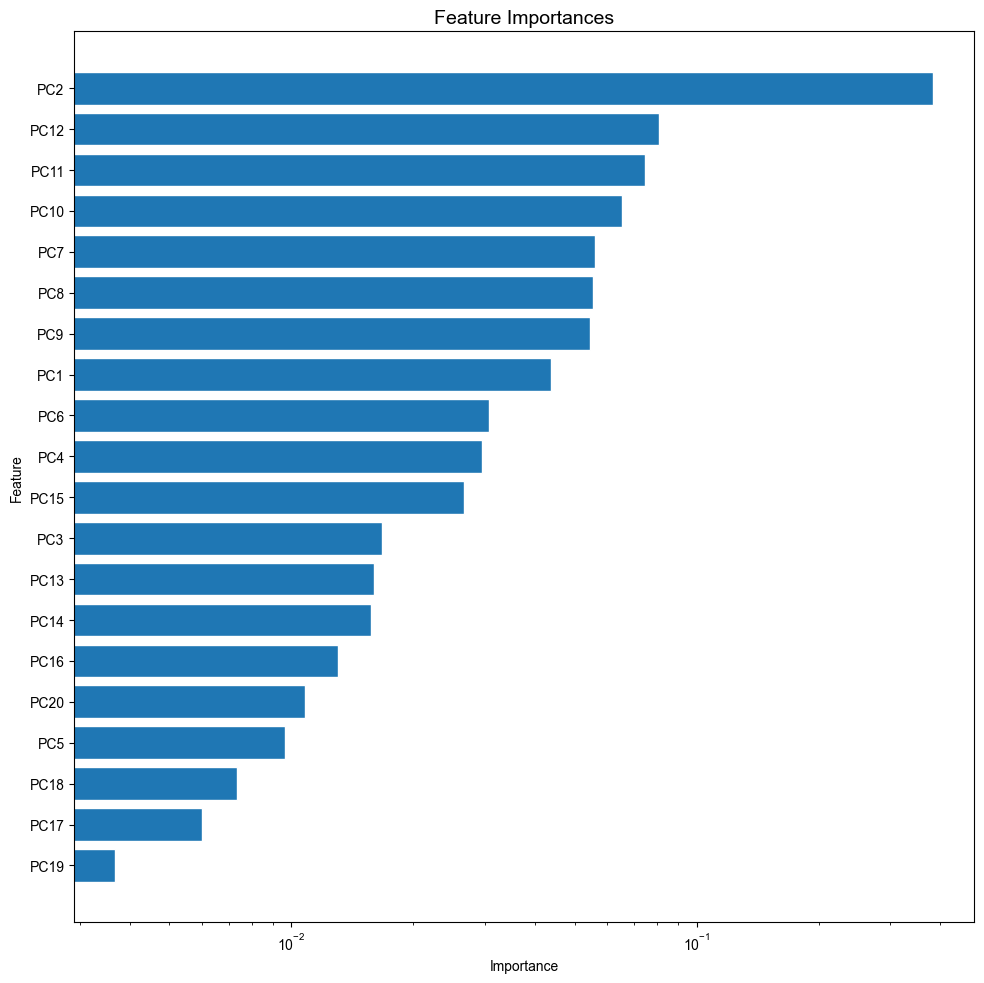

In [7]:
# finding most important features in the model

feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style='whitegrid')
sns.set_palette("viridis")

# sorting feature importances
feature_importances = feature_importances.sort_values('importance', ascending=True)

# bar chart of feature importances
ax.barh(feature_importances.index, feature_importances['importance'])

# making y axis logaritmic
ax.set_xscale('log')

ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances', fontsize=14)
ax.set_yticklabels(feature_importances.index)

fig.tight_layout()

In [8]:
# evaluating the model on the test set

class_probabilities_test = rf_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_test:.3f}")

Precision on Test Set = 0.936
Recall on Test Set = 0.714
F1 Score on Test Set = 0.810


In [9]:
# saving model
dump(rf_model, data_path/f'rf_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\rf_model_MHD.joblib']